# Team Members:
 - Aman Panwar CS20BTECH11004 
 - Amulya Tallamraju AI20BTECH11003 
 - Pranav K Nayak ES20BTECH11035 
 - Taha Adeel Mohammed CS20BTECH11052 
 - Vikhyath Sai Kothamasu CS20BTECH11056 

# Pregel framework
The below cell contains our adaptation of a simple implementation of the Pregel framework. It mainly provides us with the Vertex and Pregel classes, which allows us to perform large calculations on a graph/matrix using parallel processing.

In [71]:
""" my_pregel.py is an adaptation of the python module pregel implementing 
a toy single-machine version of Google's Pregel system for large-scale graph 
processing. """

# my_pregel.py
import collections
import threading
import time

class Vertex():
    """
    A Vertex represents a node in the graph.  It stores its id, its current 
    score, and the adjacency list of its outgoing vertices, along with the 
    values incoming into it and outgoing from it during the current superstep.
    """
    def __init__(self, id, score, out_vertices):
        self.id = id 
        self.score = score
        self.out_vertices = out_vertices
        self.incoming_weights = []
        self.outgoing_weights = []
        self.active = True
        self.superstep = 0
   

class Pregel():
    """ A Pregel instance represents a single run of the Pregel system. """
    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_weights()

    def partition_vertices(self):
        """Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices.values():
            partition[self.worker_id(vertex)].append(vertex)
        return partition

    def worker_id(self,vertex):
        """Returns the id of the worker that vertex is assigned to."""
        return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep"""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            worker.start()
        # Wait for all workers to complete
        for worker in workers:
            worker.join()

    def redistribute_weights(self):
        """Updates the weight lists for all vertices."""
        for vertex in self.vertices.values():
            vertex.superstep +=1
            vertex.incoming_weights = []
        for vertex in self.vertices.values():
            for (receiving_vertix, weight) in vertex.outgoing_weights:
                self.vertices[receiving_vertix].incoming_weights.append((vertex, weight))

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices.values()])

class Worker(threading.Thread):
    """A Worker represents a single thread in the Pregel system.  It
    is responsible for completing a single superstep for a subset of
    the vertices."""

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()
        #time.sleep(10)
        #print(f" Worker completed superstep with vertices list : {[v.id for v in self.vertices]}")
        

    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()


Import Libraries

In [72]:
import random
import matplotlib.pyplot as plt
# from pregel import Vertex, Pregel
from numpy import mat, eye, zeros, ones, linalg, argsort

# Trust-rank algorithm
Each node holds a trust score, along with its id, and the adjacency list of its outgoing vertices, along with the 
 values incoming into it and outgoing from it during the current superstep. While updating the trust scores, we propogate the bad trust scores from a bad node to its neighbours, proportional to the edge weight between them. This quantifies the assumption that a bad node majorly involves in transactions with other bad nodes.

In [73]:
class TrustRankVertex(Vertex):
    """ A TrustRankVertex represents a node in the graph.  It stores its id, its 
    current score, and the adjacency list of its outgoing vertices, along with the 
    values incoming into it and outgoing from it during the current superstep.
    """
    def __init__(self, id, score, out_vertices, dampingFactor=0.85, iterations=50):
        Vertex.__init__(self, id, score, out_vertices)
        self.dampingFactor = dampingFactor # Damping factor
        self.num_supersteps = iterations # Number of supersteps
        self.out_vertices = {}  # Dictionary to store outgoing vertices and their weights
        self.score = score  # Initial score of the vertex
        self.total_out_weight = 0  # Total weight of outgoing edges

    def update(self):
        if self.superstep < self.num_supersteps:  # Check if the current superstep is less than the total number of supersteps
            incoming_trustrank_sum = 0  # Initialize the sum of TrustRank scores from incoming vertices
            for (vertex, weight) in self.incoming_weights:  # Iterate over incoming vertices and their weights
                incoming_trustrank_sum += weight  # Add the weight to the sum

            # Update the score of the vertex using the TrustRank formula
            self.score = (1 - self.dampingFactor) / num_vertices + self.dampingFactor * incoming_trustrank_sum

            num_of_neighbors = len(self.out_vertices)  # Get the number of neighbors (outgoing vertices)

            if self.total_out_weight > 0:
                # Update the weights of outgoing vertices based on the TrustRank score and the weight of each outgoing vertex
                self.outgoing_weights = [(vertex, self.score * (weight/self.total_out_weight)) for (vertex, weight) in self.out_vertices.items()]
            else:
                # If there are no outgoing vertices, set the weights to zero
                self.outgoing_weights = [(vertex, 0) for (vertex, weight) in self.out_vertices.items()]

        else:
            self.active = False  # If the current superstep is equal to or exceeds the total number of supersteps, set the vertex as inactive


# Graph
Below we read and form the weighted, directed, simple graph representing the transactions between the nodes, on which we will apply the trust rank algo, knowing a few bad nodes. We initially assign a trust score of 1/|bad nodes| to each bad node, and 0 to all other nodes.

In [74]:
class Graph:
    vertices = {}
    bad_nodes = []

    """ Get the list of bad nodes from file"""
    def getBadNodes(self, filename):
        print(f"Reading bad nodes from {filename}")
        with open(filename,'r') as file:
            file.readline() # Ignore the first line containing the header
            self.bad_nodes = [int(node) for node in file.read().splitlines()]

    """ Get the the vertices and edges along with their weigths from file"""
    def getGraph(self, filename):
        print(f"Reading graph from {filename}")
        with open(filename,'r') as file:
            file.readline() # Ignore the first line containing the header
            for edge in file.read().splitlines():
                frm, to, edge_weight = edge.split(',')
                frm, to, edge_weight = int(frm) , int(to), float(edge_weight) 
                if frm not in self.vertices:
                    self.vertices[frm] = TrustRankVertex(frm, 0, {})
                if to not in self.vertices:
                    self.vertices[to] = TrustRankVertex(to, 0, {})
                if to not in self.vertices[frm].out_vertices:
                    self.vertices[frm].out_vertices[to] = 0
                self.vertices[frm].out_vertices[to] += edge_weight # Add edge weight to the vertex
                self.vertices[frm].total_out_weight += edge_weight

    def intialTrustRank(self):
        """ Intialiaze score for each node. For Trust Rank it is 1/|bad_nodes|
        for the bad nodes and 0 for the rest of the nodes"""
        for vertex_id in self.vertices:
            if vertex_id in self.bad_nodes:
                self.vertices[vertex_id].score = 1/len(self.bad_nodes)
            else:
                self.vertices[vertex_id].score = 0

# Trust rank algorithm using Pregel framework

In [75]:
def pregelTrustRank(vertices, num_workers = 20):
    """ Compute Pagerank using pregel by assissting set of vertices to thread """
    p = Pregel(vertices, num_workers)
    p.run()
    return mat([vertex.score for vertex in p.vertices.values()]).transpose()

# Matrix-Based Trust Rank Algorithm
We map each node id to its index in the dictionary, and form the adjacency matrix of the graph. We then form the transition matrix, and the initial trust vector, and use the formula trust_vector = (1-d) * transition_matrix * trust_vector + d * initial_trust_vector to update the trust vector, where d is the damping factor.

In [76]:
def trustrank_test(vertices):
    """Computes the trust rank vector associated to vertices, using a
    standard matrix-theoretic approach to computing trustrank.  This is
    used as a basis for comparison."""
    num_vertices = len(vertices)
    I = mat(eye(num_vertices))
    G = zeros((num_vertices, num_vertices))

    # As the node id's can be larger than the number of nodes, we need to create a mapping from node id to index in the vertices dictionary
    index = {}
    for i, vertex_id in enumerate(vertices):
        index[vertex_id] = i
    
    for vertex in vertices.values():
        for (out_vertex_id, weight) in vertex.out_vertices.items():
            G[index[out_vertex_id], index[vertex.id]] = weight / vertex.total_out_weight
    P = (1.0/num_vertices)*mat(ones((num_vertices,1)))

    return 0.15*((I-0.85*G).I)*P

# Main function
Below we run the algorithm on our graph, and viusalize the output and accuracy of pergels framework

In [77]:
# Set up the graph
graph = Graph()
graph.getBadNodes("bad.csv")
graph.getGraph("Iron_dealers_data.csv")
graph.intialTrustRank()
num_vertices = len(graph.vertices)
print("Set up graph with " + str(num_vertices) + " vertices and " + str(len(graph.bad_nodes)) + " bad nodes\n")


Reading bad nodes from bad.csv
Reading graph from Iron_dealers_data.csv
Set up graph with 799 vertices and 20 bad nodes



In [78]:
# Compute trustrank using pregel
print("Computing trust rank using pregel\n")
pregel_trustrank = pregelTrustRank(graph.vertices)

trustrank_pregal = {}
for vertex in graph.vertices.values():
    trustrank_pregal[vertex.id] = vertex.score
sorted_trustrank_pregal = sorted(trustrank_pregal.items(), key=lambda x: x[1], reverse=True)

print("Pregal scores:", sorted_trustrank_pregal)

Computing trust rank using pregel

Pregal scores: [(1088, 0.03657394430976734), (1144, 0.03568251444266552), (1007, 0.024310801362824052), (1094, 0.011916677916890613), (1201, 0.011274153810394198), (1173, 0.01099958784091173), (1122, 0.010519572726655314), (1041, 0.009535834346174547), (1138, 0.0072750876211957775), (1050, 0.007195702390225238), (1043, 0.007046597107659652), (1381, 0.006982794426377115), (1330, 0.006232833503896238), (1038, 0.005898860691832913), (1319, 0.005723832233821227), (1021, 0.005681554371193211), (1037, 0.005525714137937298), (1283, 0.005417824323681727), (1114, 0.0053268955863886485), (1084, 0.005034540511923777), (1076, 0.004971504519785271), (1139, 0.004904076397102987), (1246, 0.004859501108763239), (1077, 0.004797274648478574), (1133, 0.004684764868335292), (1103, 0.004639357238015963), (1370, 0.004631529130105166), (1193, 0.004432867266465753), (1276, 0.004292054337653068), (1034, 0.004264166946183847), (1087, 0.004242088766092578), (1033, 0.00418245264

In [79]:
print("Computing trust rank using matrix multiplication\n")
matrix_trustrank = trustrank_test(graph.vertices)

trustrank_matrix = {}
vertex_id_list = list(graph.vertices.keys())
for i in range(len(vertex_id_list)):
    trustrank_matrix[vertex_id_list[i]] = matrix_trustrank[i,0]
sorted_trustrank_matrix = sorted(trustrank_matrix.items(), key=lambda x: x[1], reverse=True)
print("Matrix multiplication scores:", sorted_trustrank_matrix)

Computing trust rank using matrix multiplication

Matrix multiplication scores: [(1088, 0.036581349703505364), (1144, 0.03569117473003544), (1007, 0.02431147425474711), (1094, 0.011926585822627622), (1201, 0.011274418292244586), (1173, 0.011010137477285702), (1122, 0.01052951821314483), (1041, 0.009546351524028263), (1138, 0.007275212076773389), (1050, 0.0071959389085181815), (1043, 0.007050664215818462), (1381, 0.006987545160100712), (1330, 0.006237405575273865), (1038, 0.005899050883764554), (1319, 0.005723993805024334), (1021, 0.005681731044805705), (1037, 0.00552582899434196), (1283, 0.005417961002134398), (1114, 0.00532700052164848), (1084, 0.005034675465716346), (1076, 0.004971595872170442), (1139, 0.004904186797837091), (1246, 0.004859608509857774), (1077, 0.004798060883658634), (1133, 0.004684847957039118), (1103, 0.0046394158920789585), (1370, 0.004631646740065884), (1193, 0.004433963839831393), (1276, 0.00429215034253967), (1034, 0.00426424030229244), (1087, 0.004242891212673

In [80]:
# Comparing the top 20 nodes from both methods
print("Comparing the top 20 nodes from both methods")
for i in range(20):
	print(f"Pregal: {sorted_trustrank_pregal[i][0]} - {round(sorted_trustrank_pregal[i][1], 8)} \t\t Matrix: {sorted_trustrank_matrix[i][0]} - {round(sorted_trustrank_matrix[i][1], 8)}")

Comparing the top 20 nodes from both methods
Pregal: 1088 - 0.03657394 		 Matrix: 1088 - 0.03658135
Pregal: 1144 - 0.03568251 		 Matrix: 1144 - 0.03569117
Pregal: 1007 - 0.0243108 		 Matrix: 1007 - 0.02431147
Pregal: 1094 - 0.01191668 		 Matrix: 1094 - 0.01192659
Pregal: 1201 - 0.01127415 		 Matrix: 1201 - 0.01127442
Pregal: 1173 - 0.01099959 		 Matrix: 1173 - 0.01101014
Pregal: 1122 - 0.01051957 		 Matrix: 1122 - 0.01052952
Pregal: 1041 - 0.00953583 		 Matrix: 1041 - 0.00954635
Pregal: 1138 - 0.00727509 		 Matrix: 1138 - 0.00727521
Pregal: 1050 - 0.0071957 		 Matrix: 1050 - 0.00719594
Pregal: 1043 - 0.0070466 		 Matrix: 1043 - 0.00705066
Pregal: 1381 - 0.00698279 		 Matrix: 1381 - 0.00698755
Pregal: 1330 - 0.00623283 		 Matrix: 1330 - 0.00623741
Pregal: 1038 - 0.00589886 		 Matrix: 1038 - 0.00589905
Pregal: 1319 - 0.00572383 		 Matrix: 1319 - 0.00572399
Pregal: 1021 - 0.00568155 		 Matrix: 1021 - 0.00568173
Pregal: 1037 - 0.00552571 		 Matrix: 1037 - 0.00552583
Pregal: 1283 - 0.005417

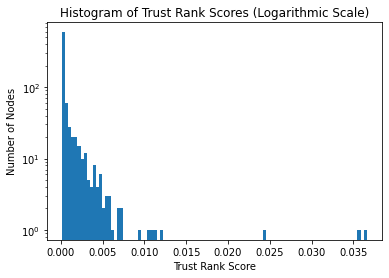

In [81]:
# Plot the distribution of the scores as a histogram on a logaritmic scale on y axis
plt.hist([vertex.score for vertex in graph.vertices.values()], bins=100)
plt.xlabel("Trust Rank Score")
plt.ylabel("Number of Nodes")
plt.title("Histogram of Trust Rank Scores (Logarithmic Scale)")
plt.yscale('log')
plt.show()